In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

2024-06-04 09:39:50.352441: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 09:39:50.880969: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Function to read the data
def dataReader(path_names):
    data_n = pd.DataFrame()
    for path in path_names:
        low_data = pd.read_csv(path, header=None)
        data_n = pd.concat([data_n, low_data], ignore_index=True)
    return data_n

def downSampler(data, a, b):
    """
    data = data
    a = start index
    b = sampling rate
    """
    data_decreased = []
    x = b
    for i in range(int(len(data) / x)):
        segment = data.iloc[a:b, :].sum() / x
        data_decreased.append(segment)
        a += x
        b += x
    return pd.DataFrame(data_decreased)

In [3]:
# Define the database path
database_path = '/home/ecappiell/datasets/full'  # Change this to the correct path

# Dictionary to store directories with their corresponding descriptive names
directory_info = {
    'normal': glob.glob(database_path + '/normal/*.csv'),
    'imbalance_6g': glob.glob(database_path + '/imbalance/6g/*.csv'),
    'imbalance_10g': glob.glob(database_path + '/imbalance/10g/*.csv'),
    'imbalance_15g': glob.glob(database_path + '/imbalance/15g/*.csv'),
    'imbalance_20g': glob.glob(database_path + '/imbalance/20g/*.csv'),
    'imbalance_25g': glob.glob(database_path + '/imbalance/25g/*.csv'),
    'imbalance_30g': glob.glob(database_path + '/imbalance/30g/*.csv'),
    'horizontal_05': glob.glob(database_path + '/horizontal-misalignment/0.5mm/*.csv'),
    'horizontal_1': glob.glob(database_path + '/horizontal-misalignment/1.0mm/*.csv'),
    'horizontal_15': glob.glob(database_path + '/horizontal-misalignment/1.5mm/*.csv'),
    'horizontal_2': glob.glob(database_path + '/horizontal-misalignment/2.0mm/*.csv'),
    'vertical_05': glob.glob(database_path + '/vertical-misalignment/0.51mm/*.csv'),
    'vertical_063': glob.glob(database_path + '/vertical-misalignment/0.63mm/*.csv'),
    'vertical_127': glob.glob(database_path + '/vertical-misalignment/1.27mm/*.csv'),
    'vertical_140': glob.glob(database_path + '/vertical-misalignment/1.40mm/*.csv'),
    'vertical_178': glob.glob(database_path + '/vertical-misalignment/1.78mm/*.csv'),
    'vertical_19': glob.glob(database_path + '/vertical-misalignment/1.90mm/*.csv'),
    'overhang_ball_0g': glob.glob(database_path + '/overhang/ball_fault/0g/*.csv'),
    'overhang_ball_6g': glob.glob(database_path + '/overhang/ball_fault/6g/*.csv'),
    'overhang_ball_20g': glob.glob(database_path + '/overhang/ball_fault/20g/*.csv'),
    'overhang_ball_35g': glob.glob(database_path + '/overhang/ball_fault/35g/*.csv'),
    'overhang_cage_0g': glob.glob(database_path + '/overhang/cage_fault/0g/*.csv'),
    'overhang_cage_6g': glob.glob(database_path + '/overhang/cage_fault/6g/*.csv'),
    'overhang_cage_20g': glob.glob(database_path + '/overhang/cage_fault/20g/*.csv'),
    'overhang_cage_35g': glob.glob(database_path + '/overhang/cage_fault/35g/*.csv'),
    'overhang_outer_0g': glob.glob(database_path + '/overhang/outer_race/0g/*.csv'),
    'overhang_outer_6g': glob.glob(database_path + '/overhang/outer_race/6g/*.csv'),
    'overhang_outer_20g': glob.glob(database_path + '/overhang/outer_race/20g/*.csv'),
    'overhang_outer_35g': glob.glob(database_path + '/overhang/outer_race/35g/*.csv'),
    'underhang_ball_0g': glob.glob(database_path + '/underhang/ball_fault/0g/*.csv'),
    'underhang_ball_6g': glob.glob(database_path + '/underhang/ball_fault/6g/*.csv'),
    'underhang_ball_20g': glob.glob(database_path + '/underhang/ball_fault/20g/*.csv'),
    'underhang_ball_35g': glob.glob(database_path + '/underhang/ball_fault/35g/*.csv'),
    'underhang_cage_0g': glob.glob(database_path + '/underhang/cage_fault/0g/*.csv'),
    'underhang_cage_6g': glob.glob(database_path + '/underhang/cage_fault/6g/*.csv'),
    'underhang_cage_20g': glob.glob(database_path + '/underhang/cage_fault/20g/*.csv'),
    'underhang_cage_35g': glob.glob(database_path + '/underhang/cage_fault/35g/*.csv'),
    'underhang_outer_0g': glob.glob(database_path + '/underhang/outer_race/0g/*.csv'),
    'underhang_outer_6g': glob.glob(database_path + '/underhang/outer_race/6g/*.csv'),
    'underhang_outer_20g': glob.glob(database_path + '/underhang/outer_race/20g/*.csv'),
    'underhang_outer_35g': glob.glob(database_path + '/underhang/outer_race/35g/*.csv')
}

In [4]:
# Dictionary to store the data frames with their corresponding descriptive names
data_frames = {}

# Iterate through the directory_info dictionary and read the data, then downsample it
for key, dir_csv_files in directory_info.items():
    data_frame = dataReader(dir_csv_files)
    data_frame_downsampled = downSampler(data_frame, 0, 5000)
    data_frames[key] = data_frame_downsampled

# Combine all the data into a single DataFrame with labels
combined_data = pd.DataFrame()
for label, df in data_frames.items():
    df['label'] = label
    combined_data = pd.concat([combined_data, df], ignore_index=True)

# Shuffle the combined data
combined_data = combined_data.sample(frac=1).reset_index(drop=True)

# Separate features and labels
X = combined_data.drop('label', axis=1).values
y = combined_data['label'].values

# Encode the labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [5]:
# Define the 1-D CNN model
def create_cnn_model(input_shape):
    model = Sequential([
        Conv1D(128, kernel_size=4, activation='relu', input_shape=input_shape),
        Conv1D(256, kernel_size=4, activation='relu'),
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(len(np.unique(y_encoded)), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Reshape data for CNN input
X_train_cnn = X_train[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

cnn_model = create_cnn_model(X_train_cnn.shape[1:])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = cnn_model.fit(X_train_cnn, y_train, epochs=300, validation_split=0.2, callbacks=[early_stopping])

/home/ecappiell/dev/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300


2024-06-04 09:44:26.686357: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 09:44:26.704577: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 09:44:26.704738: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

 190/1906 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.0321 - loss: 3.6638

I0000 00:00:1717494271.010086  753069 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1881/1906 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.0738 - loss: 3.1617

I0000 00:00:1717494273.098962  753341 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_65', 192 bytes spill stores, 192 bytes spill loads



1906/1906 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.0741 - loss: 3.1589 - val_accuracy: 0.1208 - val_loss: 2.7644
Epoch 2/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 2s 912us/step - accuracy: 0.1268 - loss: 2.7478 - val_accuracy: 0.1908 - val_loss: 2.4345
Epoch 3/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 2s 904us/step - accuracy: 0.1818 - loss: 2.4966 - val_accuracy: 0.2165 - val_loss: 2.3360
Epoch 4/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 2s 911us/step - accuracy: 0.2063 - loss: 2.3763 - val_accuracy: 0.2335 - val_loss: 2.2422
Epoch 5/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 2s 906us/step - accuracy: 0.2240 - loss: 2.3263 - val_accuracy: 0.2430 - val_loss: 2.2194
Epoch 6/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 2s 907us/step - accuracy: 0.2318 - loss: 2.2839 - val_accuracy: 0.2503 - val_loss: 2.1977
Epoch 7/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 2s 909us/step - accuracy: 0.2348 - loss: 2.2706 - val_accuracy: 0.2510 - val_loss: 2.1826
Epoch 8/300
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 2s 901us/step - accuracy: 0.2430 - loss:

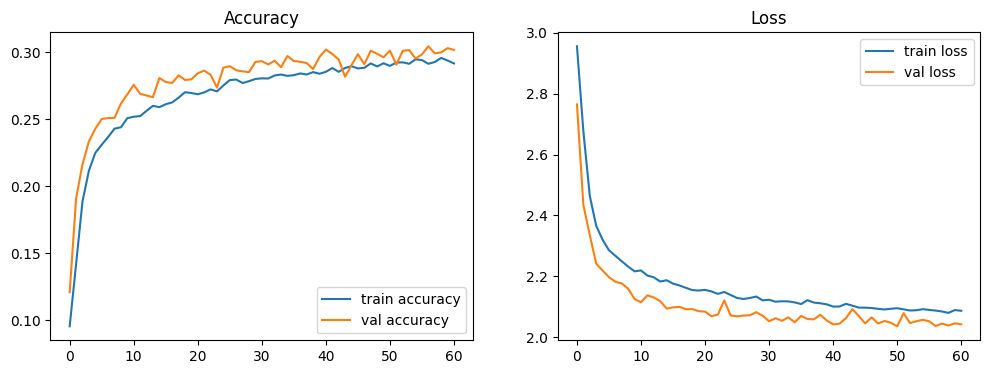

In [6]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')

plt.show()

In [7]:
# Evaluate the CNN model
cnn_pred = cnn_model.predict(X_test_cnn)
cnn_pred_classes = np.argmax(cnn_pred, axis=1)

531/596 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step

I0000 00:00:1717494382.021785  759217 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_47', 260 bytes spill stores, 260 bytes spill loads



596/596 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [8]:
# Function to print evaluation metrics
def print_metrics(y_true, y_pred):
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted')}")
    print(f"Recall: {recall_score(y_true, y_pred, average='weighted')}")
    print(f"F1 Score: {f1_score(y_true, y_pred, average='weighted')}")
    print(f"Confusion Matrix:\n {confusion_matrix(y_true, y_pred)}")

print("CNN Model Performance:")
print_metrics(y_test, cnn_pred_classes)

CNN Model Performance:
Accuracy: 0.30362014690451206
Precision: 0.32511822174090643
Recall: 0.30362014690451206
F1 Score: 0.2919906048319113
Confusion Matrix:
 [[ 53  38  44 ...   0   1   5]
 [  8  67   1 ...   0   0   4]
 [ 32  22  61 ...   0   0   7]
 ...
 [  0   1   0 ...   5  29 167]
 [  0   1   0 ...   7  22 243]
 [  0   0   2 ...   5  15 300]]
